In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_excel(r'C:\Users\Adam\Desktop\Food Quality\data\Data_Train.xlsx', sheet_name=0)
test_data = pd.read_excel(r'C:\Users\Adam\Desktop\Food Quality\data\Data_Test.xlsx', sheet_name=0)

train_data.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,NaN,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4


In [3]:
train_data.columns = train_data.columns.str.lower()
test_data.columns = test_data.columns.str.lower()

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
id                    147443 non-null int64
date                  147443 non-null object
licenseno             147443 non-null int64
facilityid            147443 non-null int64
facilityname          147443 non-null int64
type                  143958 non-null object
street                147443 non-null int64
city                  147443 non-null object
state                 147443 non-null object
locationid            147408 non-null float64
reason                147443 non-null object
sectionviolations     108375 non-null float64
risklevel             147443 non-null object
geo_loc               147443 non-null object
inspection_results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49148 entries, 0 to 49147
Data columns (total 14 columns):
id                   49148 non-null int64
date                 49148 non-null object
licenseno            49148 non-null int64
facilityid           49148 non-null int64
facilityname         49148 non-null int64
type                 47933 non-null object
street               49148 non-null int64
city                 49148 non-null object
state                49148 non-null object
locationid           49133 non-null float64
reason               49148 non-null object
sectionviolations    36172 non-null float64
risklevel            49148 non-null object
geo_loc              49148 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 5.2+ MB


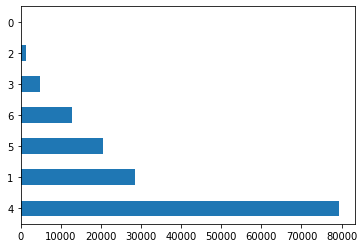

In [6]:
#classes are highly imbalanced, if trained a basic model it predicts class : 4 often
train_data.inspection_results.value_counts().plot(kind='barh')

In [7]:
(train_data[train_data['sectionviolations'].isnull()]['reason'].value_counts() / train_data.reason.value_counts() *100).sort_values(ascending=False)

OUT OF BUSINESS                           100.000000
TASK FORCE LIQUOR 1475                     62.032086
LICENSE RE-INSPECTION                      57.107122
LICENSE-TASK FORCE                         50.900901
SHORT FORM FIRE-COMPLAINT                  45.454545
CONSULTATION                               39.960239
LICENSE                                    38.421990
COMPLAINT RE-INSPECTION                    28.558798
CANVASS RE-INSPECTION                      27.863738
RECENT INSPECTION                          27.016129
SHORT FORM COMPLAINT                       26.737338
SUSPECTED FOOD POISONING RE-INSPECTION     24.489796
CANVASS                                    23.635221
COMPLAINT-FIRE                             22.500000
TAG REMOVAL                                18.421053
COMPLAINT                                   6.100796
SUSPECTED FOOD POISONING                    3.803487
Name: reason, dtype: float64

In [8]:
target = train_data['inspection_results']
train_data.drop('inspection_results', inplace=True, axis='columns')
df = pd.concat([train_data, test_data])
df.reset_index(drop=True, inplace=True)
print(train_data.shape, test_data.shape)
print(df.shape)

df.info()

(147443, 14) (49148, 14)
(196591, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196591 entries, 0 to 196590
Data columns (total 14 columns):
id                   196591 non-null int64
date                 196591 non-null object
licenseno            196591 non-null int64
facilityid           196591 non-null int64
facilityname         196591 non-null int64
type                 191891 non-null object
street               196591 non-null int64
city                 196591 non-null object
state                196591 non-null object
locationid           196541 non-null float64
reason               196591 non-null object
sectionviolations    144547 non-null float64
risklevel            196591 non-null object
geo_loc              196591 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 21.0+ MB


In [9]:
df.sectionviolations.isna().sum()

52044

In [10]:
df.columns

Index(['id', 'date', 'licenseno', 'facilityid', 'facilityname', 'type',
       'street', 'city', 'state', 'locationid', 'reason', 'sectionviolations',
       'risklevel', 'geo_loc'],
      dtype='object')

In [11]:
indexes = df.loc[pd.to_datetime(df.date, format = '%d-%m-%Y', errors='coerce').isna()].index
for i in indexes:
    df.iloc[i,1] = df.iloc[i,1].replace('29-02','01-03')

In [12]:
df['date'] = pd.to_datetime(df.date, format='%d-%m-%Y')

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day

In [13]:
df['type'] = df.groupby('facilityname')['type'].ffill()
df['type'] = df.groupby('facilityname')['type'].bfill()

df['type'] = df.type.fillna("UNKOWN")

In [14]:
df.loc[(df.type.str.lower().str.contains('care')) | (df.type.str.lower().str.contains('livi')),'type'] = 'CARE CENTERS'
df.loc[df.type.str.lower().str.contains('mobil'), 'type'] = 'MOBILE FOOD VENDOR'
df.loc[df.type.str.lower().str.contains('hospital'), 'type'] = 'HOSPITAL'
df.loc[df.type.str.lower().str.contains('banquet'), 'type'] = 'BANQUET'
df.loc[(df.type.str.lower().str.contains('rest')) | (df.type.str.lower().str.contains('roof')), 'type'] = 'RESTAURANT'
df.loc[(df.type.str.lower().str.contains('cafe')) | (df.type.str.lower().str.contains('coffee')), 'type'] = 'CAFE'
df.loc[(df.type.str.lower().str.contains('liq')) | (df.type.str.lower().str.contains('bar')) , 'type'] = 'BAR'
df.loc[(df.type.str.lower().str.contains('kiosk'))|(df.type.str.lower().str.contains('froze'))
       | (df.type.str.lower().str.contains('food')), 'type'] = 'FOOD VENDING MACHINES'
df.loc[df.type.str.lower().str.contains('gas'), 'type'] = 'GAS STATION'
df.loc[df.type.str.lower().str.contains('grocery'), 'type'] = 'GROCERY'
df.loc[df.type.str.lower().str.contains('school'), 'type'] = 'SCHOOL'
df.loc[df.type.str.lower().str.contains('kitch'), 'type'] = 'SHARED KITCHEN'
df.loc[df.type.str.lower().str.contains('conv'), 'type'] = 'CONVENIENCE STORES'
df.loc[df.type.str.lower().str.contains('prof'), 'type'] = 'NON PROFITS'
df.loc[df.type.str.lower().str.contains('theat'), 'type'] = 'THEATER'
df.loc[df.type.str.lower().str.contains('poul'), 'type'] = 'POULTRY'

lst = ['RESTAURANT', 'GROCERY', 'SCHOOL', 'CARE CENTERS', 'UNKOWN', 'BAKERY', 
       'FOOD VENDING MACHINES', 'CATERING', 'BAR', 'HOSPITAL', 'GOLDEN DINER', 
       'WHOLESALE', 'SHARED KITCHEN', 'BANQUET', 'TAVERN', 'GAS STATION', 'SPECIAL EVENT', 
       'CAFE', 'CONVENIENCE STORES', 'POULTRY', 'SHELTER', 'THEATER', 'STADIUM', 'STORE', 
       'ICE CREAM SHOP']
df.loc[~df.type.isin(lst),'type'] = 'OTHER OUTLETS'

In [15]:
df['city'] = df.city.str.replace(r'[^0-9]','').astype('int')
df['state'] = df.state.str.replace(r'[^0-9]','').astype('int')

df['geo_loc'] = df.geo_loc.str.replace(r'[a-zA-Z]','').astype('int')

In [16]:
#df['sectionviolations'].fillna(df.groupby('facilityname')['sectionviolations'].agg(pd.Series.mode),
                                                        #inplace=True)
#df['sectionviolations'].fillna(df.groupby('reason')['sectionviolations'].agg(pd.Series.mode),
                                                        #inplace=True)

In [17]:
#can we impute sectionviolations with mode value of reasons column? 
#plt.figure(figsize=(20,15))
#plt.xticks(rotation=45)
#sns.boxplot(x='reason', y='sectionviolations', data=df)

In [18]:
df[df.city==11235901]['risklevel'].value_counts()

High         140974
Medium        38282
Low           16970
Uncertain        31
Name: risklevel, dtype: int64

In [19]:
df[df.type == 'RESTAURANT']['risklevel'].value_counts()

High         105759
Medium        24766
Low            1631
Uncertain        14
Name: risklevel, dtype: int64

In [20]:
df.loc[df.risklevel == 'Uncertain', 'risklevel'] = 'High'

In [21]:
df.risklevel.unique()

array(['High', 'Medium', 'Low'], dtype=object)

In [22]:
risk_map = {'High':3, 'Medium':2, 'Low':1}
df['risklevel'] = df.risklevel.map(risk_map)

In [27]:
df['locationid'] = df.locationid.fillna(df.groupby('geo_loc')['locationid'].transform('max'))
df['locationid'] = df.locationid.fillna(df.groupby('city')['locationid'].transform('max'))

df['locationid'] = df.locationid.astype('int')

In [24]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()

df[['type','reason']] = df[['type','reason']].apply(lencoder.fit_transform)

In [25]:
df = df[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196591 entries, 0 to 196590
Data columns (total 14 columns):
year            196591 non-null int64
month           196591 non-null int64
day             196591 non-null int64
licenseno       196591 non-null int64
facilityid      196591 non-null int64
facilityname    196591 non-null int64
type            196591 non-null int32
street          196591 non-null int64
city            196591 non-null int32
state           196591 non-null int32
locationid      196591 non-null int32
reason          196591 non-null int32
risklevel       196591 non-null int64
geo_loc         196591 non-null int32
dtypes: int32(6), int64(8)
memory usage: 16.5 MB


In [26]:
train, test = df.iloc[:train_data.shape[0],:], df.iloc[train_data.shape[0]:,:]
test.reset_index(drop=True, inplace=True)

In [210]:
X = train[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = target

In [211]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

xgb = xgb.XGBClassifier(n_jobs=-1)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [212]:
from sklearn.metrics import accuracy_score, confusion_matrix

xgb_pred = xgb.predict(X_test)

print("accuracy is:",accuracy_score(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

accuracy is: 0.5969072864151199
[[    0     2     0     0     6     3     0]
 [    0   624     2     0  6983   835    90]
 [    0    43     6     0   270   104     0]
 [    0    11     1     0  1105   268    18]
 [    0   329     1     0 22508   809   169]
 [    0   113     2     0  3844  2242    27]
 [    0     2     0     0  2457   336  1023]]


In [220]:
y_pred = xgb.predict(test)
np.unique(y_pred)

array([0, 1, 2, 4, 5, 6], dtype=int64)

In [223]:
y_pred = xgb.predict(test)

xgb_predictions = pd.get_dummies(y_pred)
xgb_predictions.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']
xgb_predictions.insert(loc=3,column='INSPECTION OVERRULED', value=0*len(xgb_predictions))
xgb_predictions.to_excel('xgb.xlsx',index=False)
xgb_predictions

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
49143,0,0,0,0,0,0,1
49144,0,0,0,0,1,0,0
49145,0,0,0,0,1,0,0
49146,0,0,0,0,0,1,0


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_train = scaler.fit_transform(train[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']].to_numpy())
scaled_train = pd.DataFrame(scaled_train.tolist(), columns=['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc'])

In [30]:
scaled_test = scaler.transform(test[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']])
scaled_test = pd.DataFrame(scaled_test.tolist(), columns=['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc'])

In [116]:
from sklearn.neighbors import KNeighborsClassifier

X = scaled_train[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = KNeighborsClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("accuracy is:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy is: 0.4926864558135329
[[    0     2     0     0     8     0     1]
 [    0  1805    43   111  5853   562   201]
 [    0   114    46     1   224    32     1]
 [    0   262     7    90   873   158    66]
 [    0  4128   116   283 17849  1049   510]
 [    0  1104    47   124  3759   952   128]
 [    1   498     0    58  1901   215  1051]]


In [121]:
y_pred = clf.predict(scaled_test)
y_pred

array([6, 4, 4, ..., 4, 5, 4], dtype=int64)

In [133]:
predictions = pd.get_dummies(y_pred)
predictions.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']
predictions

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
49143,0,0,0,0,0,0,1
49144,0,0,0,0,1,0,0
49145,0,0,0,0,1,0,0
49146,0,0,0,0,0,1,0


In [134]:
predictions.to_excel('knn.xlsx')

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split


X = scaled_train[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("accuracy is:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy is: 0.5930413944340198
[[    1     0     0     0     9     1     1]
 [   23   620     8     2  7048   795   102]
 [    0    32    12     0   291    99     1]
 [    5     6     0     8  1107   239    18]
 [   61   344     5     6 22444   754   191]
 [   10    99     6     1  3896  2117    29]
 [   12     6     0     3  2447   344  1030]]


In [34]:
#y_pred = clf.predict(scaled_test)
#y_pred

array([6, 4, 4, ..., 4, 5, 4], dtype=int64)

In [35]:
true_labels = pd.get_dummies(y_test)
true_labels.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

true_labels

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
85830,0,0,0,0,1,0,0
59496,0,0,0,0,1,0,0
92621,0,1,0,0,0,0,0
26204,0,0,0,0,1,0,0
112808,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
119367,0,0,0,0,0,1,0
83227,0,0,0,0,1,0,0
135378,0,0,0,0,1,0,0
134273,0,0,0,0,1,0,0


In [53]:
predictions = pd.get_dummies(y_pred)
predictions.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

#predictions.to_excel('gbc.xlsx')

predictions

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
44228,0,0,0,0,0,1,0
44229,0,0,0,0,1,0,0
44230,0,0,0,0,1,0,0
44231,0,0,0,0,1,0,0


In [54]:
print(log_loss(true_labels, predictions))

14.055852279628045


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split


X = scaled_train[['year', 'month', 'day', 'licenseno', 'facilityid', 'facilityname',
       'type', 'street', 'city', 'state', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

true_labels = pd.get_dummies(y_test)
true_labels.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

predictions = pd.get_dummies(y_pred)
predictions.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

print(log_loss(true_labels, predictions))

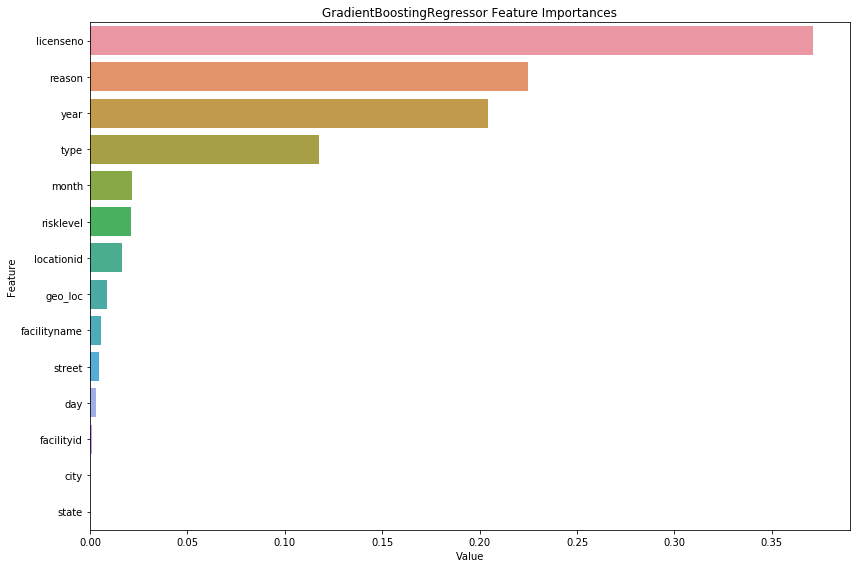

In [55]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X_train.columns), reverse=True), columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('GradientBoostingRegressor Feature Importances')
plt.tight_layout()
plt.show()

In [56]:
#dropping unimportant features the performance has improved marginally
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split


X = scaled_train[['year', 'month', 'licenseno', 'facilityname',
       'type', 'street', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

true_labels = pd.get_dummies(y_test)
true_labels.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

predictions = pd.get_dummies(y_pred)
predictions.columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN']

print(log_loss(true_labels, predictions))

13.862985465947244


In [ ]:
from keras import Sequential
from keras.layers import Dense

X = scaled_train[['year', 'month', 'licenseno', 'facilityname',
       'type', 'street', 'locationid', 'reason', 'risklevel',
       'geo_loc']]
y = pd.get_dummies(target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential([
                Dense(14,activation = 'relu',kernel_initializer='random_normal', input_dim=10),                          
                Dense(10,activation = 'relu',kernel_initializer='random_normal'),
                Dense(7, activation='softmax', kernel_initializer='random_normal'),
                ])
model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics =['categorical_accuracy'])

model.fit(X_train,y_train, batch_size=100, epochs=100)

In [83]:
scaled_test = scaled_test[['year', 'month', 'licenseno', 'facilityname',
       'type', 'street', 'locationid', 'reason', 'risklevel',
       'geo_loc']]

In [92]:
predictions = pd.DataFrame(model.predict(scaled_test), columns = ['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
                  'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN'])

predictions.to_excel('NN.xlsx')
#log_loss : 1.09894